In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp

from levee_hunter.processing.dataset_images_choice import interactive_images_selection
from levee_hunter.processing.helpers import specify_helper

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:20: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/pmucha/fathom/levee-hu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
helper_model = smp.Segformer(
    encoder_name="mit_b0",      # Use the MIT-B0 encoder for SegFormer
    encoder_weights="imagenet", # Pretrained on ImageNet
    in_channels=1,              # Input channels (e.g. grayscale images)
    classes=1                   # Number of output classes
).to(device)
helper_model.load_state_dict(torch.load("../models/1m_1024_old/Segformer-b0_old.pth"))

<All keys matched successfully>

In [ ]:
helper = specify_helper('model_helper', helper_model)

Image passed overlap check.
Progress: 275/7010 

Currently Processing: ../data/intermediate/1m_1024/images/USGS_1M_15_x32y439_MO_Northern_SEMO_2021_D21_p7.tif


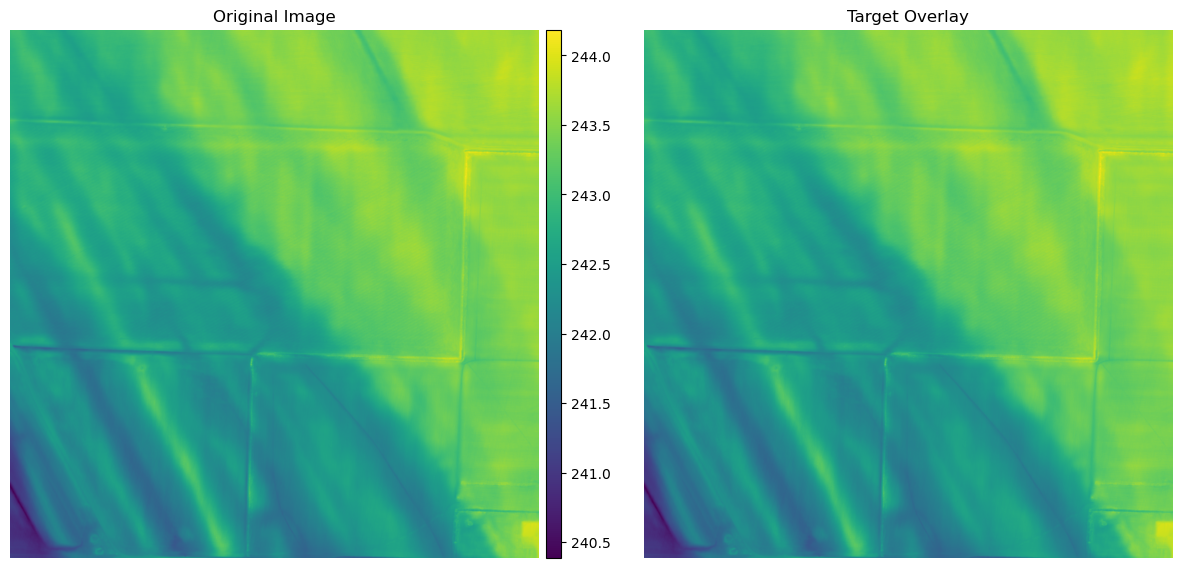

In [6]:
# please note, the dilation_size is only for visualisation.
interactive_images_selection(
    intermediate_data_path="../data/intermediate/1m_1024",
    output_dir='../data/processed/1m_1024', 
    dilation_size=7,         # for visualisation only, choose your preference
    figsize=(15, 9),         # for visualisation only
    cmap='viridis',          # for visualisation only
    plot='overlay',          # for visualisation only
    file_ids_toprocess=None,
    powernorm_threshold=40,  # for visualisation only
    store_bad_bounds=True,
    store_bad_images=True,
    helper=None,
    )

    #10080

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Segformer(
    encoder_name="mit_b0",      # Use the MIT-B0 encoder for SegFormer
    encoder_weights="imagenet", # Pretrained on ImageNet
    in_channels=1,              # Input channels (e.g., grayscale)
    classes=1                   # Number of output classes
).to(device)

# Load your checkpoint weights (fine-tuned from another dataset, for example)
checkpoint = torch.load("../models/1m_1024_old/Segformer-b0_old.pth", map_location=device)
model.load_state_dict(checkpoint)

# Create an optimizer – it will fine-tune all parameters (or only those not frozen)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [3]:
def get_model_memory_usage(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()  # in bytes

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()  # in bytes

    total_size = param_size + buffer_size
    # Convert bytes to megabytes
    return total_size / (1024 ** 2)

# Example usage:
memory_usage_mb = get_model_memory_usage(model)
print(f"Model weights memory usage: {memory_usage_mb:.2f} MB")

Model weights memory usage: 14.16 MB


In [4]:
from levee_hunter.levees_dataset import LeveesDataset

dataset = LeveesDataset(
    images_dir='../data/processed/1m_1024/images',
    masks_dir='../data/processed/1m_1024/masks',
    transform=None,
    weighted=True,
    )

len(dataset)

1626

In [ ]:
#dataset.apply_mask_type(mask_type='dilated', dilation_size=8)

Processing masks: 100%|██████████| 1626/1626 [01:54<00:00, 14.19it/s]


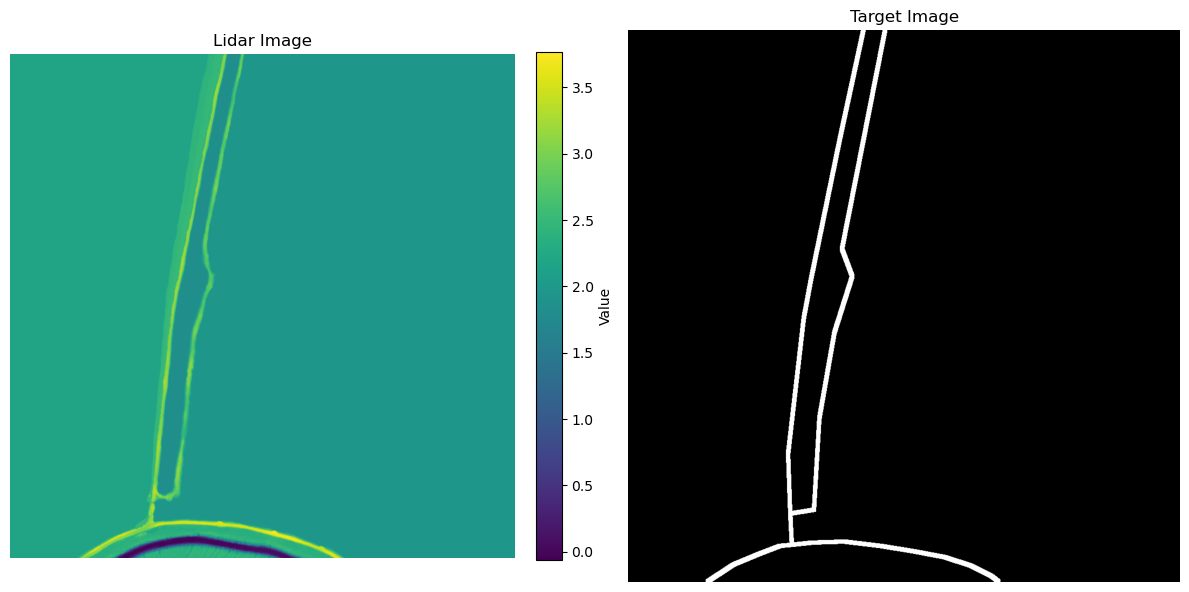

In [5]:
dataset.plot(idx=100, figsize=(12, 6), cmap='viridis', transform=False)

In [6]:
dataset.img_paths[:5]

[PosixPath('../data/processed/1m_1024/images/USGS_1M_10_x51y506_OR_OLCMetro_2019_A19_p11_w1.tif'),
 PosixPath('../data/processed/1m_1024/images/USGS_1M_10_x51y506_OR_OLCMetro_2019_A19_p15_w1.tif'),
 PosixPath('../data/processed/1m_1024/images/USGS_1M_10_x51y506_OR_OLCMetro_2019_A19_p16_w1.tif'),
 PosixPath('../data/processed/1m_1024/images/USGS_1M_10_x51y506_OR_OLCMetro_2019_A19_p18_w1.tif'),
 PosixPath('../data/processed/1m_1024/images/USGS_1M_10_x51y506_OR_OLCMetro_2019_A19_p5_w1.tif')]

In [7]:
dataset.file_ids[:5]

['USGS_1M_10_x51y506_OR_OLCMetro_2019_A19',
 'USGS_1M_10_x51y506_OR_OLCMetro_2019_A19',
 'USGS_1M_10_x51y506_OR_OLCMetro_2019_A19',
 'USGS_1M_10_x51y506_OR_OLCMetro_2019_A19',
 'USGS_1M_10_x51y506_OR_OLCMetro_2019_A19']

In [8]:
dataset.weights[:5]

[1, 1, 1, 1, 1]

In [9]:
len(list(set(dataset.file_ids)))

306

In [12]:
from levee_hunter.train_test_val_splitting import validation_split

file_ids = sorted(set(dataset.file_ids))[:45]
train_test_dataset, val_dataset = validation_split(dataset=dataset, file_ids=file_ids)

len(train_test_dataset), len(val_dataset)

(1423, 203)

In [13]:
from levee_hunter.train_test_val_splitting import train_test_split_dataset

train_dataset, test_dataset = train_test_split_dataset(dataset=train_test_dataset, test_size=0.07)

len(train_dataset), len(test_dataset), len(val_dataset)

(1323, 100, 203)

In [14]:
# we can check if their transformations are what we want them to be
train_dataset.transform, test_dataset.transform, val_dataset.transform

('train_transform', 'normalize_only', 'normalize_only')

In [15]:
# test and validation should be unweighted
test_dataset.weighted=False
val_dataset.weighted=False
train_dataset.weighted

True

In [16]:
batch_size = 14

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
len(train_loader), len(test_loader), len(val_loader)

(95, 10, 1)

In [18]:
import torch.nn as nn

from levee_hunter.modeling.train import train_model

model, train_loss, val_loss = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=nn.BCEWithLogitsLoss(reduction="none"),
    epochs=50,
    save_model='best',
    save_model_path="../models/1m_1024/Segformer-b0.pth",
)

beginning training on device: cuda
Epoch: 1/50 Train Loss: 0.024922 Val Loss: 0.016727
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 2/50 Train Loss: 0.022152 Val Loss: 0.017579
Epoch: 3/50 Train Loss: 0.021369 Val Loss: 0.015874
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 4/50 Train Loss: 0.021858 Val Loss: 0.015806
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 5/50 Train Loss: 0.020458 Val Loss: 0.015514
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 6/50 Train Loss: 0.021324 Val Loss: 0.016675
Epoch: 7/50 Train Loss: 0.020884 Val Loss: 0.015415
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 8/50 Train Loss: 0.019823 Val Loss: 0.015103
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 9/50 Train Loss: 0.019227 Val Loss: 0.015028
Model successfully saved to: ../models/1m_1024/Segformer-b0.pth
Epoch: 10/50 Train Loss: 0.018835 Val Loss: 0.014

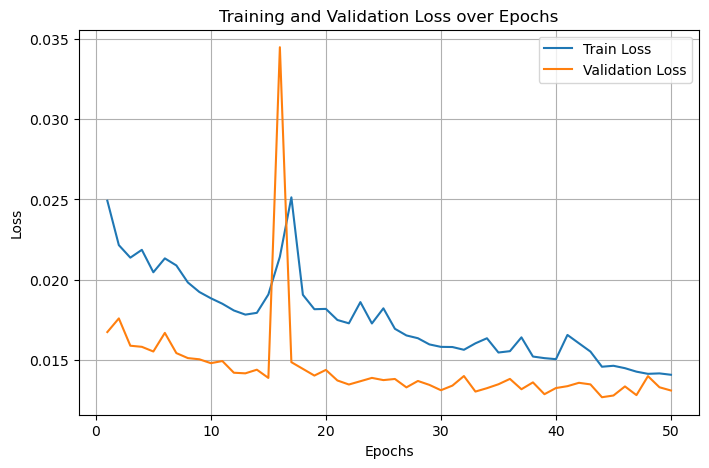

In [19]:
from levee_hunter.plots import plot_training_validation_loss
plot_training_validation_loss(train_loss[:], val_loss[:])

In [18]:
# load the saved model
model.load_state_dict(torch.load("../models/1m_1024/Segformer-b0.pth"))
model.eval()

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=

0


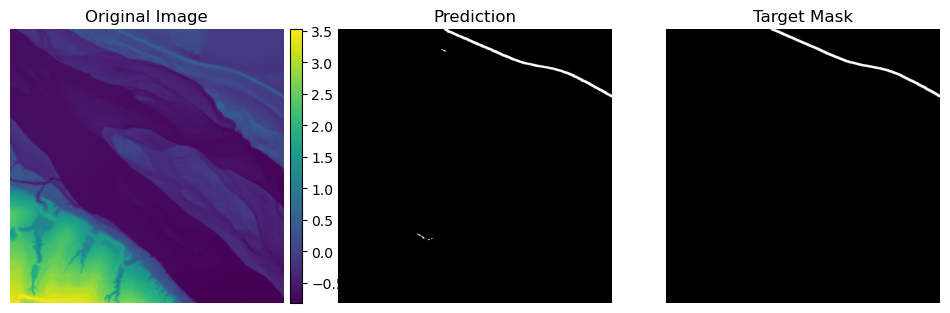

1


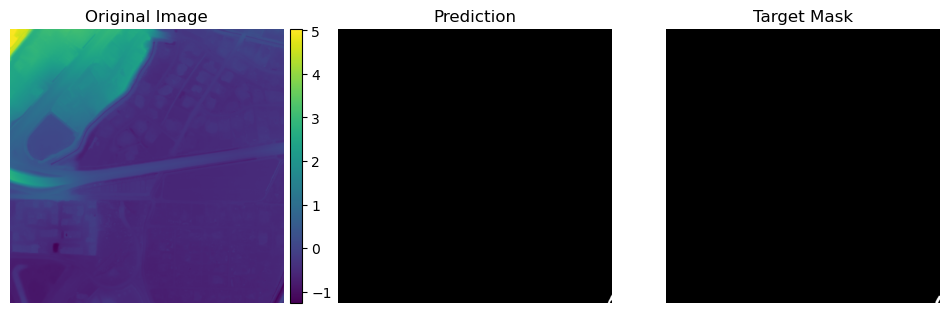

2


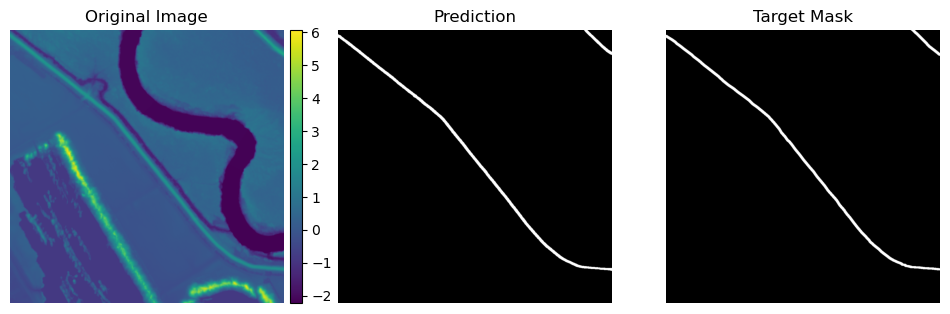

3


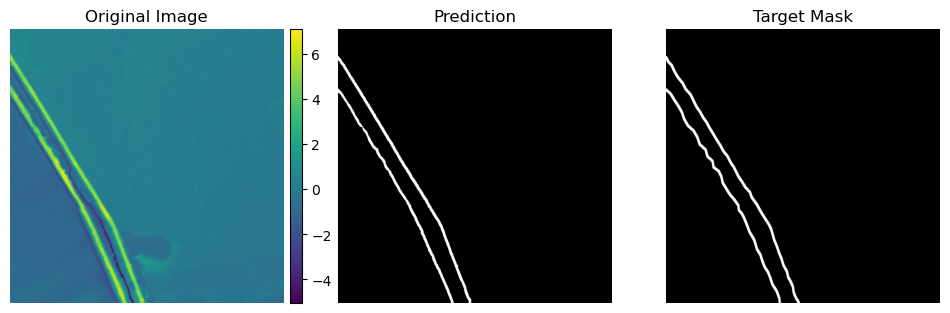

4


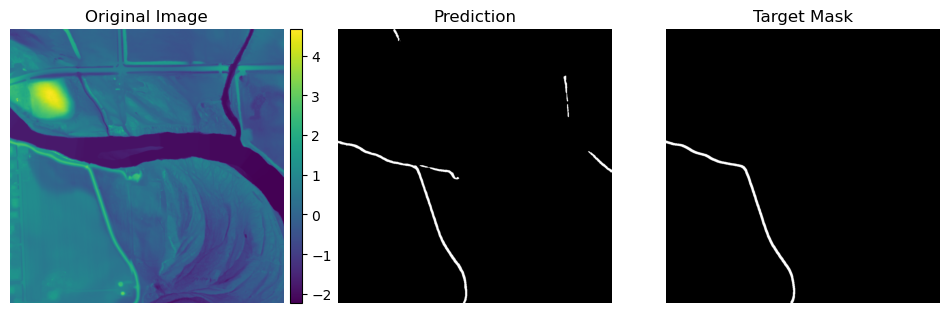

5


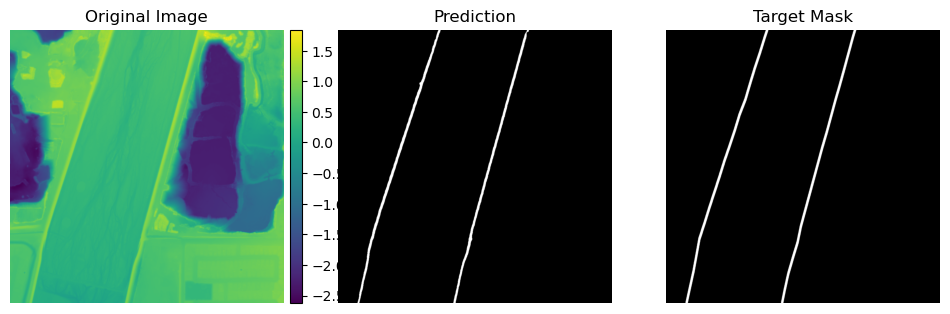

6


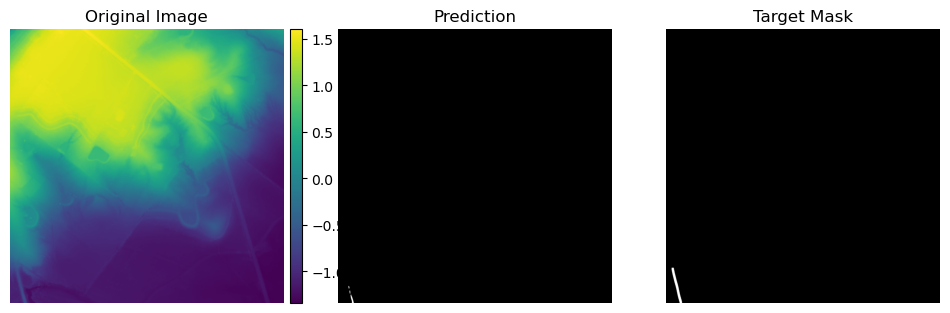

7


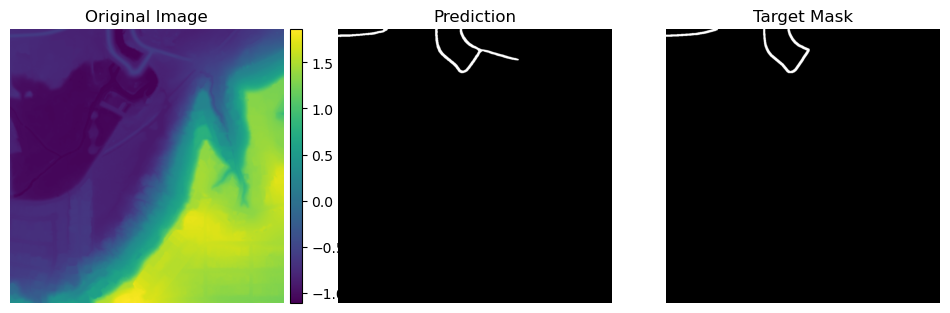

8


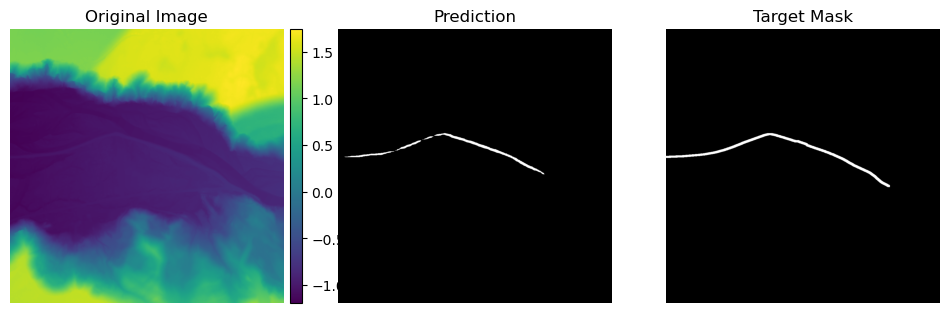

9


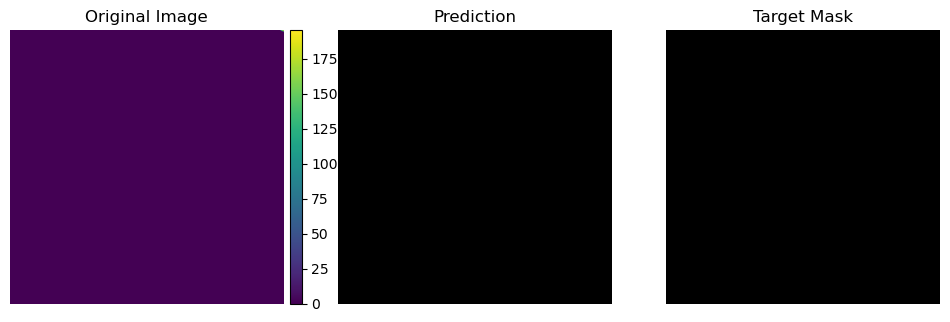

10


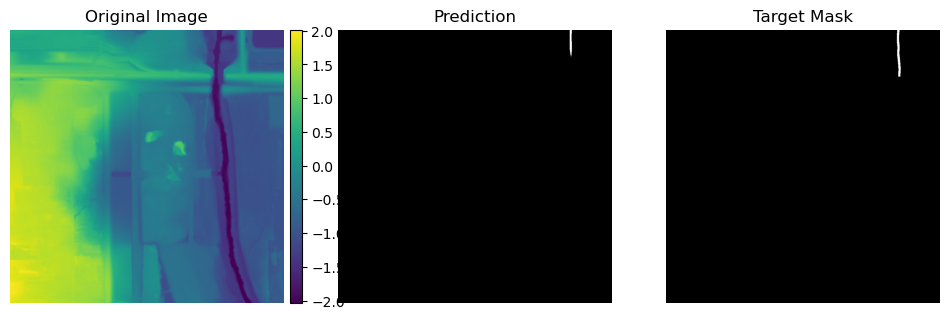

11


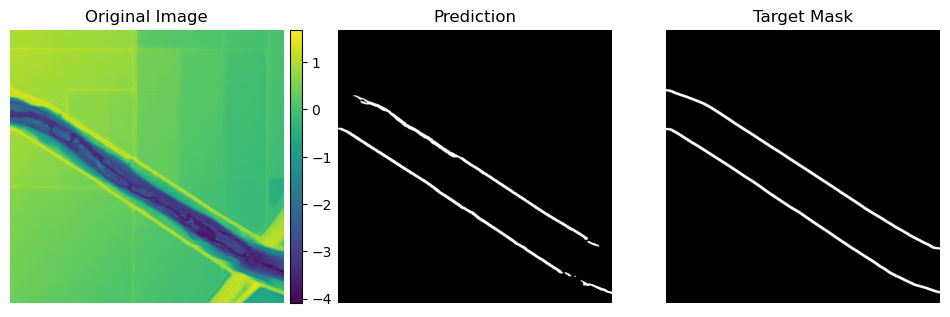

12


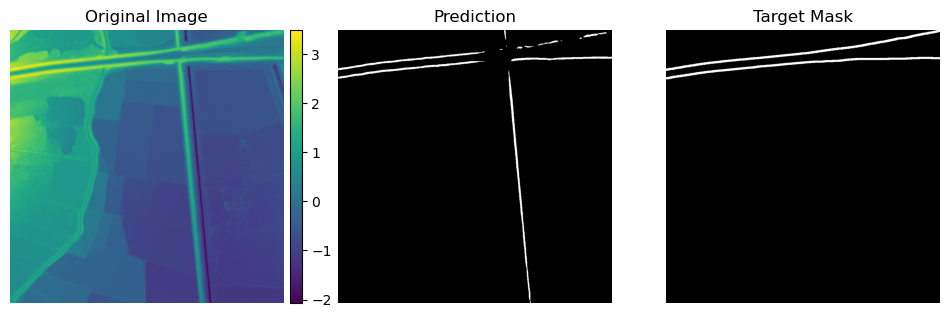

13


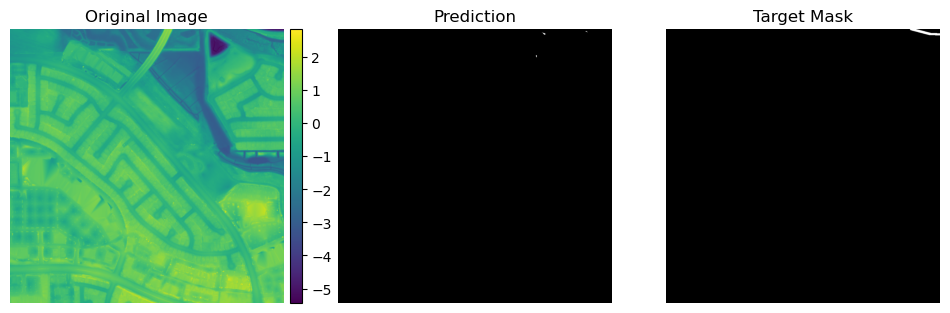

14


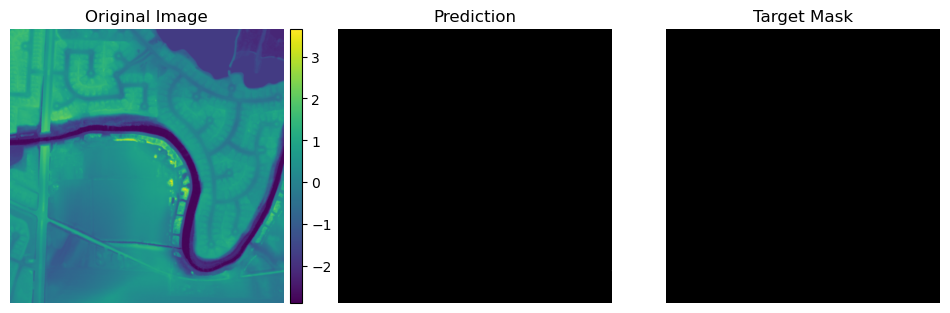

In [28]:
from levee_hunter.plots import infer_and_visualize
for ix in range(15):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    output = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

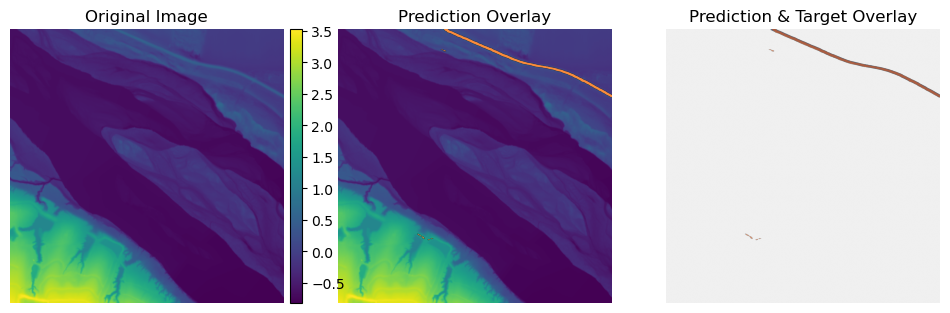

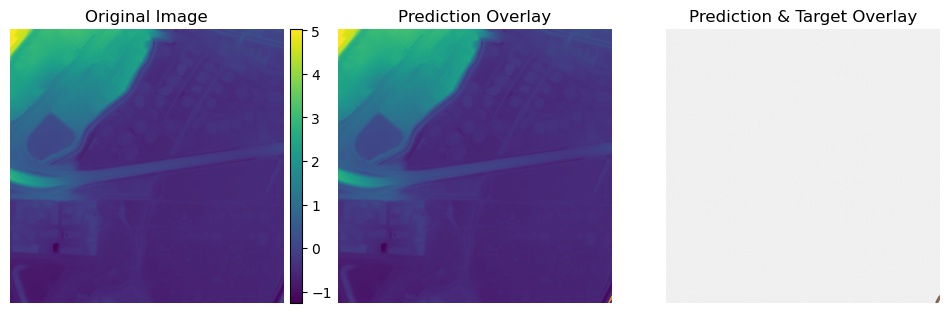

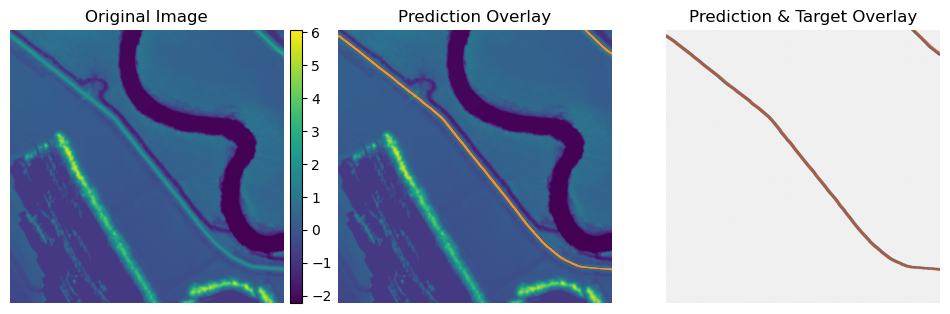

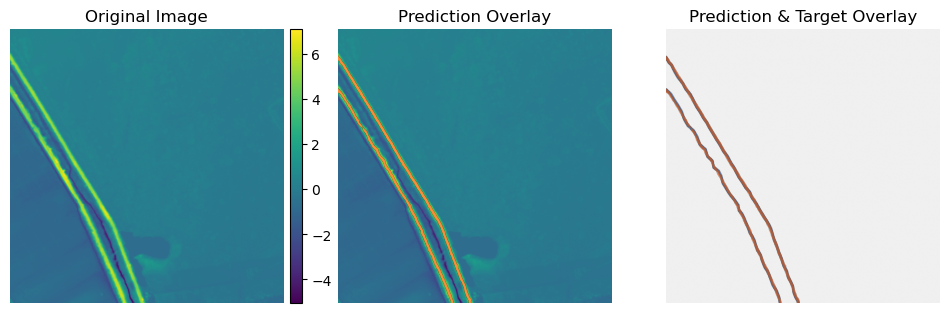

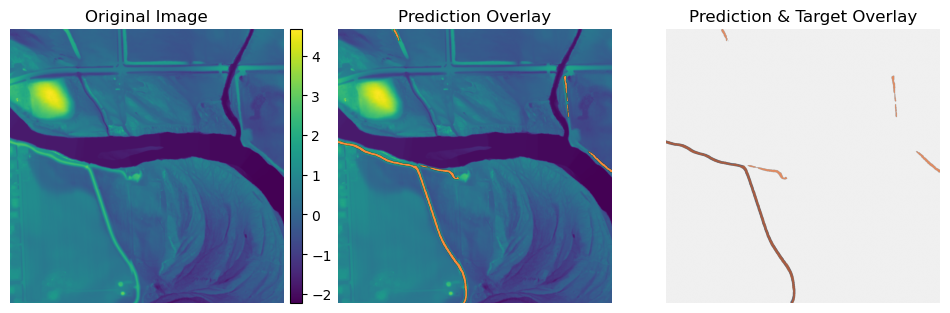

In [19]:
from levee_hunter.plots import infer_and_plot_overlap


for ix in range(5):
    img, target = test_dataset[ix]
    output = infer_and_plot_overlap(
        model=model, 
        image_tensor=img, 
        mask_tensor=target, 
        device=device, apply_sigmoid=True, 
        threshold=0.5, 
        invert=True
        )